In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
from owslib.wfs import WebFeatureService
import geopandas as gpd
import h5py 

# Data storage --> dashboard pipeline

**Goal is a dashboard showing** 
1. Graph of (normalized) indicator value(s) (DMP, VCI, El Nino Index, ...) vs. admin boundary 
2. Time series graph for a given admin of the same quantity 


**raw input data** 
1. raw TIFF files from satelite 
2. shapefiles for different admin levels and countries 

**produce datasets** 
1. HDF5 with:
    * **Groups are Admin lvl**:
        * **datasets**: table with |admin ID| normed indicator value 1| normed indicator value 2| ..... |
        * **keys**: dates  (YYYY-MM-DD)
 
 
 
2. HDF5 with datasets equal to:
      * **Groups are Admin lvl**:
        * **datasets**: table with |date | normed indicator value 1| normed indicator value 2| .......
        * **keys**: admin ID  (Pcode)
 


**we need the following scripts/functions**
1. Fetch the TIFF from satelite 
2. Fatch shapefiles from geonode.510.global
3. Use Shapefile to perform zonal statistics + append to already existing data (if historical data already extracted previously)
4. Perform normalizations 
5. Produce datasets for HDF5 file 1
6. Produce datasets for HDF5 file 2
7. Group datasets together into groups of HDF5 file 

### retreive shapefiles from geonode server 

In [48]:
from owslib.wfs import WebFeatureService
import geopandas as gpd

def collect_shapefile(layer_id):
    wfs_url ='https://geonode.510.global/geoserver/geonode_old/ows'
    wfs = WebFeatureService(wfs_url, version='2.0.0')
    
    # Get the actual data
    binary_data = wfs.getfeature(typename=layer_id, outputFormat='application/json')
    
    # write to file 
    output_filename = layer_id.replace('geonode:','') + '.geojson'
    with open(output_filename, 'wb') as f:
        f.write( binary_data.read() )
    return output_filename


def read_shapes(filename):
    layers = gpd.read_file(filename)
    shapes = list(layers['geometry'])
    return shapes 


def read_admin_ID(filename, name_id, pcode_id):
    layers = gpd.read_file(filename)
    names = list(layers[name_id] )
    pcode = list(layers[pcode_id])
    return names, pcode 
    
    
    
    
    
    


layer_id = 'eth_adm1_mapshaper_reproj'
filename = '/Users/mklein1/Desktop/Test.geojson'


x = collect_shapefile(layer_id)
    
shapes = read_shapes(filename)
admin_names, admin_pcodes = read_admin_ID(filename, name_id='REGIONNAME', pcode_id='REG_Pcode')


'eth_adm1_mapshaper_reproj.geojson'

### retreive TIFF file from satalite 

In [53]:
def get_timestamp():
    '''
    use the name of the TIFF file to understand the date that is associated to this image
    
    
    we want this when storing this new output into the HDF5 file
    '''
    pass


def collect_TIFF_image():
    pass 

### perform zonal statistics 

In [22]:
import rasterio
import rasterio.mask


def extract_zonal_stats(file_shapes, file_tiff, 
                        name_id, pcode_id,
                        minval=-np.inf,
                        maxval=np.inf,
                        statistic="mean"):

    # --- initialize ----
    zonal_stats = []

    df_out = pd.DataFrame()

    # --- open the shape file and acces wanted info ----
    shapes = read_shapes(file_shapes)
    names, pcodes = read_admin_ID(file_shapes, name_id , pcode_id)
    

    # --- use rasterio to read the satelite image (raster data/vector image) ----
    with rasterio.open(file_tiff, 'r') as src:
        # --- acces the image (the matrix with intensity values) ----
        img = src.read(1)
        # --- perform the mask operation for every shape in the shapefile ---
        for shape in shapes:
            out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)

            # --- show the masked image (shows non-zero value within boundaries, zero outside of boundaries shape) ----
            img = out_image[0, :, :]

            # --- Only use physical values, for DMP: physical min is zero ----
            data = img[(img >= minval) & (img <= maxval)]

            # --- determine metric ---
            if (statistic == "mean"):
                zonal_stats.append( data.mean()  )
            elif (statistic == "min"):
                zonal_stats.append( data.min() )
            elif (statistic == "max"):
                zonal_stats.append( data.max() )
            elif (statistic == "median"):
                zonal_stats.append( np.median(data) )
            
            

    # --- store results into dataframe ---
    df_out['pcode'] = pcode
    df_out['area'] = names
    df_out['zonal_statistic'] = zonal_stats
    return df_out, data, img

### Combine: update data with zonal statistic 
Wrapper function to 
1. collect shapes from geonode
2. collect the (latest) satalite data
3. perform zonal statistic on this (latest) TIFF 

4. Append the output to a HDF5 file with the zonal statistics sorted by admin level. 
5. Adjust the time-stamp in the metadata of the HDF5-file 




In [72]:
import pandas as pd 
import geopandas as gpd 
from owslib.wfs import WebFeatureService
import rasterio 
import rasterio.mask 

import h5py 
from datetime import date 

# --- user will build the following dictionary with all the info we need --- 
output_info = {'last modified': str(date.today()),
              'zonal statistic': 'mean', 
              'indicator':'DMP',
              'min_value':0.,
               'max_value':np.inf, 
              'shapes source':'geonode:eth_adm1_mapshaper_reproj',
              'TIFF source': 'Copernicus URL or something',
              'shape ID': 'REGIONNAME',
              'pcode ID': 'REG_P_CODE'}



def update_indicator(output_file, output_info ):
    
    # ---- get shapefile/geometry information from geonode --- 
    shapefile = collect_shapefile(layer_id=output_info['shapes source'])
    
    
    # ---- get TIFF image from satalite ---- 
    ''' call collect_TIFF_image()  here '''
    
    
    
    # ---- perform zonal statistics ---- 
    ZonalStats, _, _ = extract_zonal_stats(file_shapes=shapefile,
                                        file_tiff=output_info['TIFF source'],
                                        name_id=output_info['shape ID'],
                                        pcode_id=output_info['pcode ID'],
                                        minval=output_info['min_value'],
                                        maxval=output_info['max_value'],
                                        statistic=output_info['zonal statistic'],
                                    )
    
    
    

    
    
    # --- write this to the master data file --- 
    timestamp = decode_date_from_folder(directory)
    ZonalStats.to_hdf(output_file, key=timestamp, table=True, mode='a')
    
    
    # --- write metadata into HDF5-file ---- 
    with h5py.File(output_file,mode='a') as output:
        for key in output_info:
            output.attrs[key] = output_info[key]
        
    
    return 





In [58]:
with h5py.File('/Users/mklein1/Documents/RedCross510/Drought_IBF/drought_monitor_dashboard/v1_ET_DMP/Ethiopia_DMP_by_area_adm1.hdf5') as f:
    print(f.attrs.keys())

<KeysViewHDF5 ['CLASS', 'PYTABLES_FORMAT_VERSION', 'TITLE', 'VERSION']>


In [70]:
test_file = '/Users/mklein1/Desktop/Test.hdf5'



df = pd.DataFrame()
df['x'] = np.linspace(1,10)

df.to_hdf(test_file, key='test')
with h5py.File(test_file, 'a') as output:
        for key in output_info:
                output.attrs[key] = output_info[key]
        output.attrs['A new element'] = "A new element" 




        

with h5py.File(test_file, 'r') as Input:
    print(Input.attrs.keys())
#     for key in output_info:
#         print(key , ': ', Input.attrs[key])

data = pd.read_hdf(test_file, key='test')

<KeysViewHDF5 ['A new element', 'TIFF source', 'indicator', 'last modified', 'shapes source', 'zonal statistics']>


In [68]:
data

,x
0,1.000000
1,1.183673
2,1.367347
3,1.551020
4,1.734694
5,1.918367
6,2.102041
7,2.285714
8,2.469388
9,2.653061


In [35]:
fname = '/Volumes/BigData/RK_IBF_drought/DMP_Ethiopia/Ethiopia_DMP_by_area_adm1.hdf5'
df = pd.read_hdf(fname, key='Addis Ababa (14)')
dates = list(df.date)


data_by_time ='/Volumes/BigData/RK_IBF_drought/DMP_Ethiopia/Ethiopia_DMP_by_date_adm1_geopandas.gjson'
geodata = gpd.read_file(data_by_time)
geodata.drop('geometry',axis=1, inplace=True)


file_out = '/Volumes/BigData/RK_IBF_drought/DMP_Ethiopia/Ethiopia_DMP_by_date_adm1.hdf5'

for date, group in geodata.groupby('date'):    
    data = pd.DataFrame(group)
    data.to_hdf(file_out, key=date, table=True, mode='a')
    
    
    
    

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2012-01-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2012-01-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2012-01-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2012-10-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2012-11-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2012-11-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2013-08-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2013-09-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2013-09-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2014-05-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2014-06-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2014-06-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2015-02-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2015-02-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2015-02-28'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2015-10-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2015-10-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2015-10-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2016-06-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2016-06-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2016-06-30'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2017-03-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2017-03-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2017-03-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2017-12-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2017-12-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2017-12-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2018-08-31'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2018-09-10'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: '2018-09-20'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()

(            REGIONNAME  REG_P_CODE REG_Pcode            HRname HRpcode  \
 2794       Addis Ababa          14      ET14       Addis Ababa    ET14   
 2795              Afar           2      ET02              Afar    ET02   
 2796            Amhara           3      ET03            Amhara    ET03   
 2797  Beneshangul Gumu           6      ET06  Beneshangul Gumu    ET06   
 2798         Dire Dawa          15      ET15         Dire Dawa    ET15   
 2799           Gambela          12      ET12           Gambela    ET12   
 2800            Hareri          13      ET13            Hareri    ET13   
 2801            Oromia           4      ET04            Oromia    ET04   
 2802             SNNPR           7      ET07             SNNPR    ET07   
 2803            Somali           5      ET05            Somali    ET05   
 2804            Tigray           1      ET01            Tigray    ET01   
 
      HRparent  DMP_avg_normed   DMP_mean        date  
 2794       ET       -0.050142   9.687500 

### retreive shapefiles from Geonode server 

(33.9135347315063, -4.67730712890625, 41.9093347315063, 5.47052313253784)


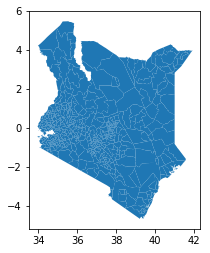

In [2]:
from owslib.wfs import WebFeatureService
wfs_url ='https://geonode.510.global/geoserver/geonode/ows'
wfs = WebFeatureService(wfs_url, version='2.0.0')

# example to download Kenya admin boundary 

layer_id = 'geonode:ken_admin3'
meta = wfs.contents[layer_id]
print(meta.boundingBoxWGS84) # if you want to be specific to the bbox defind below  

# Get the actual data
data = wfs.getfeature(typename='geonode:ken_admin3',
                      bbox=(-180.0, -90.0, 180.0, 90), ## Boundaries: (-180.0, -90.0, 180.0, 83.64513) 
                      outputFormat='application/json')
 
# Write to file
filename = '/Users/mklein1/Desktop/Test.geojson'
with open(filename, 'wb') as fn:
    fn.write(data.read())
    
layers = gpd.read_file(filename)
layers.plot()

In [6]:
shapes = list( layers["geometry"] )
shapes

In [89]:
import requests
req = requests.get( wfs11.getGETGetFeatureRequest('geonode:eth_adm1_mapshaper_reproj') )



In [94]:
import shapely
import shapefile
shapefile.Reader(req.content)

ShapefileException: Shapefile Reader requires a shapefile or file-like object.

KeyboardInterrupt: 

In [69]:
fname = '/Users/mklein1/Documents/RedCross510/Drought_IBF/shapefiles/Ethiopia/Administrative boundaries/ETH_adm2_mapshaper_reproj.shp'

with fiona.open(fname) as f:
    print(f.meta['driver'] )
    
    

    
    
with fiona.open('/Users/mklein1/Desktop/Test.shp','w',
               driver=f.meta['driver'],
               schema=f.meta['schema']) as shapefile:
    binary_data = wfs11.getfeature('geonode:eth_adm2_mapshaper_reproj')
    shapefile.write( binary_data) 
    

ESRI Shapefile


TypeError: '_io.BytesIO' object is not subscriptable

In [61]:
wfs11.contents

{'geonode:IRAB_BASIn_lev6': <owslib.feature.wfs200.ContentMetadata at 0x10d552f50>,
 'geonode:nam_stations': <owslib.feature.wfs200.ContentMetadata at 0x10d552d10>,
 'geonode:nga_polbnda_adm0_1m': <owslib.feature.wfs200.ContentMetadata at 0x10d552f10>,
 'geonode:nga_polbnda_adm1_1m_salb': <owslib.feature.wfs200.ContentMetadata at 0x10d552810>,
 'geonode:nga_admbnda_adm2_osgof_20170222': <owslib.feature.wfs200.ContentMetadata at 0x10d552b50>,
 'geonode:dissolved_modis': <owslib.feature.wfs200.ContentMetadata at 0x10d552790>,
 'geonode:nga_osm_roads': <owslib.feature.wfs200.ContentMetadata at 0x10d552710>,
 'geonode:nga_rds_1m_dcw': <owslib.feature.wfs200.ContentMetadata at 0x10d552090>,
 'geonode:towns_points': <owslib.feature.wfs200.ContentMetadata at 0x10d53fdd0>,
 'geonode:gis_osm_water_a_free_1': <owslib.feature.wfs200.ContentMetadata at 0x10d53f710>,
 'geonode:gis_osm_waterways_free_1': <owslib.feature.wfs200.ContentMetadata at 0x10d53fc50>,
 'geonode:buildings': <owslib.feature.wf

TypeError: descriptor 'get_driver' of 'fiona.ogrext.Session' object needs an argument

In [45]:
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r'}

In [4]:
with h5py.File('/Users/mklein1/Desktop/TestieTest.hdf5','w') as f:
    f.create_group('Admin lvl')
    f.create_dataset('Admin lvl/date',data=[1,5,23])
    
    
    
    
    

In [8]:
with h5py.File('/Users/mklein1/Desktop/TestieTest.hdf5','r') as f:
    data = f['Admin lvl/date'][:]

In [11]:
df = pd.DataFrame([1,3,4])
df.to_hdf('/Users/mklein1/Desktop/TestieTest.hdf5',mode='w',key='Admin lvl/date')

/Users/mklein1/anaconda3/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'Admin lvl'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


In [15]:
with h5py.File('/Users/mklein1/Desktop/TestieTest.hdf5','r') as f:
    g = f['Admin lvl']
    print(g.keys())

<KeysViewHDF5 ['date']>
